# Few Shot Sampling of Blood Smear Images

## Custom Dataloader

In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [3]:

def resize_and_pad(image, target_size=(320, 320), fill=0):
    """
    Resize an image to fit within the target size while preserving the aspect ratio,
    then pad the shorter sides with a constant value to reach the target size.

    Args:
        image (PIL.Image): Input image.
        target_size (tuple): Target size (width, height), default (224, 224).
        fill (int or tuple): Padding fill value (e.g., 0 for black, 255 for white).

    Returns:
        PIL.Image: Resized and padded image of size target_size.
    """
    # Get original dimensions
    width, height = image.size
    target_width, target_height = target_size

    # Calculate scaling factor to fit within target size
    scale = min(target_width / width, target_height / height)
    new_width = int(width * scale)
    new_height = int(height * scale)

    # Resize image with correct (height, width) order
    resized_image = transforms.functional.resize(image, (new_height, new_width))

    # Calculate padding to center the image
    padding_left = (target_width - new_width) // 2
    padding_top = (target_height - new_height) // 2
    # Ensure padding adds up exactly to the difference
    padding_right = target_width - new_width - padding_left
    padding_bottom = target_height - new_height - padding_top

    # Apply padding
    padded_image = transforms.functional.pad(
        resized_image,
        padding=(padding_left, padding_top, padding_right, padding_bottom),
        fill=fill
    )

    return padded_image

In [4]:
# Basic Image transformation
def get_base_transforms(target_size=(320, 320), use_grayscale=False):
    """
    Returns a composed set of basic image transformations for preprocessing input images.

    Parameters:
    - target_size (tuple): The desired output size (height, width) of the image after resizing and padding.
    - use_grayscale (bool): If True, converts the image to grayscale with 3 channels before applying other transformations.

    Returns:
    - torchvision.transforms.Compose: A sequence of transformations including:
        - Optional grayscale conversion with 3 output channels,
        - Resizing and padding the image to match the target size,
        - Conversion to tensor,
        - Normalization using ImageNet mean and standard deviation.
    """
    base_transforms = [
        transforms.Lambda(lambda img: resize_and_pad(img, target_size=target_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]

    if use_grayscale:
        base_transforms.insert(0, transforms.Grayscale(num_output_channels=3))  # Keep 3 channels for compatibility
    return transforms.Compose(base_transforms)


# Data augmentation transforms
def get_augmentation_transforms():
    """
    Returns a composed set of data augmentation transformations to artificially expand the training dataset.

    This function applies a series of random transformations to simulate variations in brightness, contrast, orientation,
    and color mode, helping the model generalize better.

    Returns:
    - torchvision.transforms.Compose: A sequence of transformations including:
        - Random brightness and contrast adjustment (ColorJitter),
        - Random horizontal and vertical flipping,
        - Random rotation by up to ±10 degrees,
        - Random conversion to grayscale with a 20% probability.
    """
    return transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Simulate lighting/stain variations
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.RandomGrayscale(p=0.2)  # Optional: Randomly apply grayscale as part of augmentation
    ])


In [5]:
class FewShotDataset(Dataset):
    def __init__(self, data_dir, split, num_ways=5, num_support=5,
                 num_query=10, num_episodes=100, target_size=(320, 320),
                 use_grayscale=False,
                 augment=False,
                 ):
        """
        Args:
            data_dir (str): Path to dataset directory
            split (str): One of 'train', 'validation', or 'test'
            num_ways (int): Number of classes per episode
            num_support (int): Number of support samples per class (i.e. number of shots)
            num_query (int): Number of query samples per class
            num_episodes (int): Number of episodes per epoch
            use_grayscale(bool),  Use grayscale or not
            augment(bool),        For data augmentation technique
        """
        self.split_dir = os.path.join(data_dir, split)
        self.num_ways = num_ways
        self.num_support = num_support
        self.num_query = num_query
        self.num_episodes = num_episodes
        base_transform = get_base_transforms(target_size, use_grayscale)
        if augment:
            augmentation_transform = get_augmentation_transforms()
            self.transform = transforms.Compose([augmentation_transform, base_transform])
        else:
            self.transform = base_transform

        # Load class directories and their images
        self.classes = [c for c in os.listdir(self.split_dir)
                       if os.path.isdir(os.path.join(self.split_dir, c))]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}  # Map class names to indices
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}  # Map indices to class names
        self.class_images = {
            c: [os.path.join(self.split_dir, c, img)
                for img in os.listdir(os.path.join(self.split_dir, c))]
            for c in self.classes
        }

    def __len__(self):
        return self.num_episodes

    def __getitem__(self, index):
        # Randomly select N classes for this episode
        selected_classes = np.random.choice(self.classes, self.num_ways, replace=False)

        support_images = []
        support_labels = []
        query_images = []
        query_labels = []

        for label_idx, class_name in enumerate(selected_classes):
            all_images = self.class_images[class_name]
            if len(all_images) < self.num_support + self.num_query:
                raise ValueError(
                    f"Class {class_name} has only {len(all_images)} images. "
                    f"Need at least {self.num_support + self.num_query}."
                )

            # Randomly select support and query images
            selected_indices = np.random.choice(
                len(all_images),
                self.num_support + self.num_query,
                replace=False #True#########################################################################
            )
            support_paths = [all_images[i] for i in selected_indices[:self.num_support]]
            query_paths = [all_images[i] for i in selected_indices[self.num_support:]]

            # Load and transform support images
            for path in support_paths:
                img = Image.open(path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                support_images.append(img)
                support_labels.append(label_idx)

            # Load and transform query images
            for path in query_paths:
                img = Image.open(path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                query_images.append(img)
                query_labels.append(label_idx)

        # Shuffle the support and query sets
        support_indices = np.arange(len(support_images))
        query_indices = np.arange(len(query_images))
        np.random.shuffle(support_indices)
        np.random.shuffle(query_indices)

        support_images = [support_images[i] for i in support_indices]
        support_labels = [support_labels[i] for i in support_indices]
        query_images = [query_images[i] for i in query_indices]
        query_labels = [query_labels[i] for i in query_indices]

        # Convert lists to tensors
        support_set = (
            torch.stack(support_images),
            torch.tensor(support_labels, dtype=torch.long)
        )
        query_set = (
            torch.stack(query_images),
            torch.tensor(query_labels, dtype=torch.long)
        )
        # Store the selected class names for this episode
        selected_classes = [str(cls) for cls in selected_classes]
        episode_classes = selected_classes

        return support_set, query_set, episode_classes

In [6]:
def get_data_loader(dataset, batch_size=1, shuffle=True):
    """
    Returns DataLoader for the dataset.
    Note: Batch size should typically be 1 for few-shot learning,
    as each episode is a separate task.
    """
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=2,
        pin_memory=True
    )

## Modelling

### Embedding Based

#### Mount Drive

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')
# Adjust data_dir based on your Drive structure
# data_dir = '/content/drive/MyDrive/Computer vision with few shot sampling focus group/data_set'
# output_dir = '/content/drive/MyDrive/Computer vision with few shot sampling focus group/protonet_results' # For saving models/plots

data_dir = "/home/ifihan/multi-dease-detection/data_set"
output_dir = "/home/ifihan/multi-dease-detection/results"  # For saving models/plots

In [8]:
import torch.nn as nn

def euclidean_distance(query_embeddings, prototype_embeddings):
    """
    Calculates the Euclidean distance between query embeddings and prototypes.
    Args:
        query_embeddings (Tensor): shape (num_query_total, embedding_dim)
        prototype_embeddings (Tensor): shape (num_ways, embedding_dim)
    Returns:
        distances (Tensor): shape (num_query_total, num_ways)
    """
    num_query_total = query_embeddings.size(0)
    num_ways = prototype_embeddings.size(0)
    # Expand dimensions for broadcasting:
    # query: (num_query_total, 1, embedding_dim)
    # proto: (1, num_ways, embedding_dim)
    distances = (query_embeddings.unsqueeze(1) - prototype_embeddings.unsqueeze(0)).pow(2).sum(dim=2)
    # Result shape: (num_query_total, num_ways)
    return distances

class PrototypicalNetwork(nn.Module):
    def __init__(self, encoder):
        """
        Args:
            encoder (nn.Module): The feature extractor network.
        """
        super().__init__()
        self.encoder = encoder

    def calculate_prototypes(self, support_embeddings, support_labels, num_ways):
        """
        Calculates class prototypes from support set embeddings.
        Args:
            support_embeddings (Tensor): Embeddings of the support set (num_support_total, embedding_dim).
            support_labels (Tensor): Labels for the support set (num_support_total).
            num_ways (int): Number of classes in the episode.
        Returns:
            prototypes (Tensor): Class prototypes (num_ways, embedding_dim).
        """
        embedding_dim = support_embeddings.size(-1)
        prototypes = torch.zeros(num_ways, embedding_dim, device=support_embeddings.device)
        for i in range(num_ways):
            class_mask = (support_labels == i)
            class_embeddings = support_embeddings[class_mask]
            if class_embeddings.shape[0] > 0: # Handle cases where a class might have 0 examples (shouldn't happen with good data)
                 prototypes[i] = class_embeddings.mean(dim=0)
            else:
                 # Optional: Handle this case e.g., with a small random vector or zero vector
                 print(f"Warning: Class {i} had 0 support examples in prototype calculation.")
                 prototypes[i] = torch.zeros(embedding_dim, device=support_embeddings.device)
        return prototypes

    def forward(self, support_images, support_labels, query_images):
        """
        Processes an episode (support and query sets) to produce logits for query samples.
        Args:
            support_images (Tensor): Images of the support set (num_support_total, C, H, W).
            support_labels (Tensor): Labels for the support set (num_support_total).
            query_images (Tensor): Images of the query set (num_query_total, C, H, W).
        Returns:
            logits (Tensor): Negative distances (logits) for query classification (num_query_total, num_ways).
        """
        num_support_total = support_images.size(0)
        num_query_total = query_images.size(0)
        num_ways = int(support_labels.max()) + 1 # Infer num_ways from labels

        # Concatenate support and query images for efficient encoding
        all_images = torch.cat([support_images, query_images], dim=0)
        all_embeddings = self.encoder(all_images)

        # Split embeddings back into support and query
        support_embeddings = all_embeddings[:num_support_total]
        query_embeddings = all_embeddings[num_support_total:]

        # Calculate prototypes
        prototypes = self.calculate_prototypes(support_embeddings, support_labels, num_ways)

        # Calculate distances between query embeddings and prototypes
        distances = euclidean_distance(query_embeddings, prototypes)

        # Return negative distances as logits (closer distance = higher probability)
        return -distances

# --- Accuracy Helper ---
def calculate_accuracy(logits, targets):
    """Calculates classification accuracy."""
    predictions = torch.argmax(logits, dim=1)
    accuracy = (predictions == targets).float().mean()
    return accuracy.item()

In [9]:
# --- Training and Evaluation Functions ---

from tqdm import tqdm

def train_epoch(model, dataloader, optimizer, criterion, device):
    """Runs a single training epoch."""
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = 0

    # Use tqdm for progress bar
    with tqdm(dataloader, desc="Training", leave=False) as pbar:
        for batch in pbar:
            # Data loader yields episodes one by one (batch_size=1 typically)
            # Squeeze the batch dimension (index 0)
            support_set, query_set, _ = batch # Ignore episode_classes for training
            support_images, support_labels = support_set
            query_images, query_labels = query_set

            # Remove the extra batch dimension of 1
            support_images = support_images.squeeze(0).to(device)
            support_labels = support_labels.squeeze(0).to(device)
            query_images = query_images.squeeze(0).to(device)
            query_labels = query_labels.squeeze(0).to(device)

            optimizer.zero_grad()

            # Forward pass
            logits = model(support_images, support_labels, query_images)

            # Calculate loss
            loss = criterion(logits, query_labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate accuracy for the episode
            accuracy = calculate_accuracy(logits, query_labels)

            total_loss += loss.item()
            total_accuracy += accuracy
            num_batches += 1

            # Update progress bar description
            pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{accuracy:.4f}")

    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    avg_accuracy = total_accuracy / num_batches if num_batches > 0 else 0
    return avg_loss, avg_accuracy

def evaluate(model, dataloader, criterion, device, description="Evaluating"):
    """Evaluates the model on a dataset."""
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = 0

    with torch.no_grad(): # Disable gradient calculations
        # Use tqdm for progress bar
        with tqdm(dataloader, desc=description, leave=False) as pbar:
            for batch in pbar:
                support_set, query_set, _ = batch
                support_images, support_labels = support_set
                query_images, query_labels = query_set

                # Remove the extra batch dimension of 1
                support_images = support_images.squeeze(0).to(device)
                support_labels = support_labels.squeeze(0).to(device)
                query_images = query_images.squeeze(0).to(device)
                query_labels = query_labels.squeeze(0).to(device)

                # Forward pass
                logits = model(support_images, support_labels, query_images)

                # Calculate loss
                loss = criterion(logits, query_labels)

                # Calculate accuracy
                accuracy = calculate_accuracy(logits, query_labels)

                total_loss += loss.item()
                total_accuracy += accuracy
                num_batches += 1

                # Update progress bar description
                pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{accuracy:.4f}")


    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    avg_accuracy = total_accuracy / num_batches if num_batches > 0 else 0
    return avg_loss, avg_accuracy

Using device: cuda
Setting up datasets...
Train dataset: 28 classes found.
Validation dataset: 4 classes found.

--- Starting Training ---

Epoch 1/50


Train Loss: 3.1049, Train Accuracy: 0.6457


Validation Loss: 1.2187, Validation Accuracy: 0.6308
Validation accuracy improved (0.0000 -> 0.6308). Saving model...

Epoch 2/50


Train Loss: 0.5603, Train Accuracy: 0.7853


Validation Loss: 1.0347, Validation Accuracy: 0.6850
Validation accuracy improved (0.6308 -> 0.6850). Saving model...

Epoch 3/50


Train Loss: 0.3835, Train Accuracy: 0.8507


Validation Loss: 1.0077, Validation Accuracy: 0.6955
Validation accuracy improved (0.6850 -> 0.6955). Saving model...

Epoch 4/50


Train Loss: 0.2698, Train Accuracy: 0.8988


Validation Loss: 1.2062, Validation Accuracy: 0.6697
No improvement in validation accuracy for 1 epochs.

Epoch 5/50


Train Loss: 0.1870, Train Accuracy: 0.9321


Validation Loss: 1.3442, Validation Accuracy: 0.6750
No improvement in validation accuracy for 2 epochs.

Epoch 6/50


Train Loss: 0.1445, Train Accuracy: 0.9483


Validation Loss: 1.3100, Validation Accuracy: 0.6703
No improvement in validation accuracy for 3 epochs.

Epoch 7/50


Train Loss: 0.1109, Train Accuracy: 0.9582


Validation Loss: 1.4001, Validation Accuracy: 0.6642
No improvement in validation accuracy for 4 epochs.

Epoch 8/50


Train Loss: 0.0943, Train Accuracy: 0.9681


Validation Loss: 1.2488, Validation Accuracy: 0.6805
No improvement in validation accuracy for 5 epochs.

Epoch 9/50


Train Loss: 0.0690, Train Accuracy: 0.9750


Validation Loss: 1.0743, Validation Accuracy: 0.7088
Validation accuracy improved (0.6955 -> 0.7088). Saving model...

Epoch 10/50


Train Loss: 0.0598, Train Accuracy: 0.9798


Validation Loss: 1.1448, Validation Accuracy: 0.7113
Validation accuracy improved (0.7088 -> 0.7113). Saving model...

Epoch 11/50


Train Loss: 0.0581, Train Accuracy: 0.9792


Validation Loss: 1.3250, Validation Accuracy: 0.6852
No improvement in validation accuracy for 1 epochs.

Epoch 12/50


Train Loss: 0.0651, Train Accuracy: 0.9767


Validation Loss: 1.2911, Validation Accuracy: 0.6872
No improvement in validation accuracy for 2 epochs.

Epoch 13/50


Train Loss: 0.0517, Train Accuracy: 0.9815


Validation Loss: 1.4677, Validation Accuracy: 0.6670
No improvement in validation accuracy for 3 epochs.

Epoch 14/50


Train Loss: 0.0464, Train Accuracy: 0.9838


Validation Loss: 1.3310, Validation Accuracy: 0.6990
No improvement in validation accuracy for 4 epochs.

Epoch 15/50


Train Loss: 0.0486, Train Accuracy: 0.9840


Validation Loss: 1.4908, Validation Accuracy: 0.6897
No improvement in validation accuracy for 5 epochs.

Epoch 16/50


Train Loss: 0.0446, Train Accuracy: 0.9860


Validation Loss: 1.6499, Validation Accuracy: 0.6682
No improvement in validation accuracy for 6 epochs.

Epoch 17/50


Train Loss: 0.0456, Train Accuracy: 0.9846


Validation Loss: 1.2839, Validation Accuracy: 0.7033
No improvement in validation accuracy for 7 epochs.

Epoch 18/50


Train Loss: 0.0483, Train Accuracy: 0.9845


Validation Loss: 1.1243, Validation Accuracy: 0.6992
No improvement in validation accuracy for 8 epochs.

Epoch 19/50


Train Loss: 0.0253, Train Accuracy: 0.9902


Validation Loss: 1.2348, Validation Accuracy: 0.6973
No improvement in validation accuracy for 9 epochs.

Epoch 20/50


Train Loss: 0.0510, Train Accuracy: 0.9843


Validation Loss: 1.0246, Validation Accuracy: 0.7255
Validation accuracy improved (0.7113 -> 0.7255). Saving model...

Epoch 21/50


Train Loss: 0.0381, Train Accuracy: 0.9878


Validation Loss: 1.3606, Validation Accuracy: 0.7160
No improvement in validation accuracy for 1 epochs.

Epoch 22/50


Train Loss: 0.0311, Train Accuracy: 0.9898


Validation Loss: 1.1636, Validation Accuracy: 0.7140
No improvement in validation accuracy for 2 epochs.

Epoch 23/50


Train Loss: 0.0425, Train Accuracy: 0.9858


Validation Loss: 1.1535, Validation Accuracy: 0.6858
No improvement in validation accuracy for 3 epochs.

Epoch 24/50


Train Loss: 0.0313, Train Accuracy: 0.9899


Validation Loss: 1.0809, Validation Accuracy: 0.7290
Validation accuracy improved (0.7255 -> 0.7290). Saving model...

Epoch 25/50


Train Loss: 0.0364, Train Accuracy: 0.9878


Validation Loss: 1.1638, Validation Accuracy: 0.6848
No improvement in validation accuracy for 1 epochs.

Epoch 26/50


Train Loss: 0.0211, Train Accuracy: 0.9931


Validation Loss: 0.9438, Validation Accuracy: 0.7555
Validation accuracy improved (0.7290 -> 0.7555). Saving model...

Epoch 27/50


Train Loss: 0.0283, Train Accuracy: 0.9924


Validation Loss: 1.2772, Validation Accuracy: 0.6847
No improvement in validation accuracy for 1 epochs.

Epoch 28/50


Train Loss: 0.0599, Train Accuracy: 0.9828


Validation Loss: 1.1059, Validation Accuracy: 0.7077
No improvement in validation accuracy for 2 epochs.

Epoch 29/50


Train Loss: 0.0303, Train Accuracy: 0.9901


Validation Loss: 0.9542, Validation Accuracy: 0.7253
No improvement in validation accuracy for 3 epochs.

Epoch 30/50


Train Loss: 0.0224, Train Accuracy: 0.9922


Validation Loss: 0.9697, Validation Accuracy: 0.7247
No improvement in validation accuracy for 4 epochs.

Epoch 31/50


Train Loss: 0.0230, Train Accuracy: 0.9938


Validation Loss: 0.9429, Validation Accuracy: 0.7348
No improvement in validation accuracy for 5 epochs.

Epoch 32/50


Train Loss: 0.0287, Train Accuracy: 0.9902


Validation Loss: 0.9482, Validation Accuracy: 0.7177
No improvement in validation accuracy for 6 epochs.

Epoch 33/50


Train Loss: 0.0270, Train Accuracy: 0.9923


Validation Loss: 1.0090, Validation Accuracy: 0.7112
No improvement in validation accuracy for 7 epochs.

Epoch 34/50


Train Loss: 0.0320, Train Accuracy: 0.9893


Validation Loss: 0.8576, Validation Accuracy: 0.7323
No improvement in validation accuracy for 8 epochs.

Epoch 35/50


Train Loss: 0.0382, Train Accuracy: 0.9883


Validation Loss: 1.1027, Validation Accuracy: 0.6733
No improvement in validation accuracy for 9 epochs.

Epoch 36/50


Train Loss: 0.0424, Train Accuracy: 0.9857


Validation Loss: 0.9178, Validation Accuracy: 0.7183
No improvement in validation accuracy for 10 epochs.
Early stopping triggered after 36 epochs.

--- Training Finished ---
Training history plot saved to /home/ifihan/multi-dease-detection/results/training_history.png


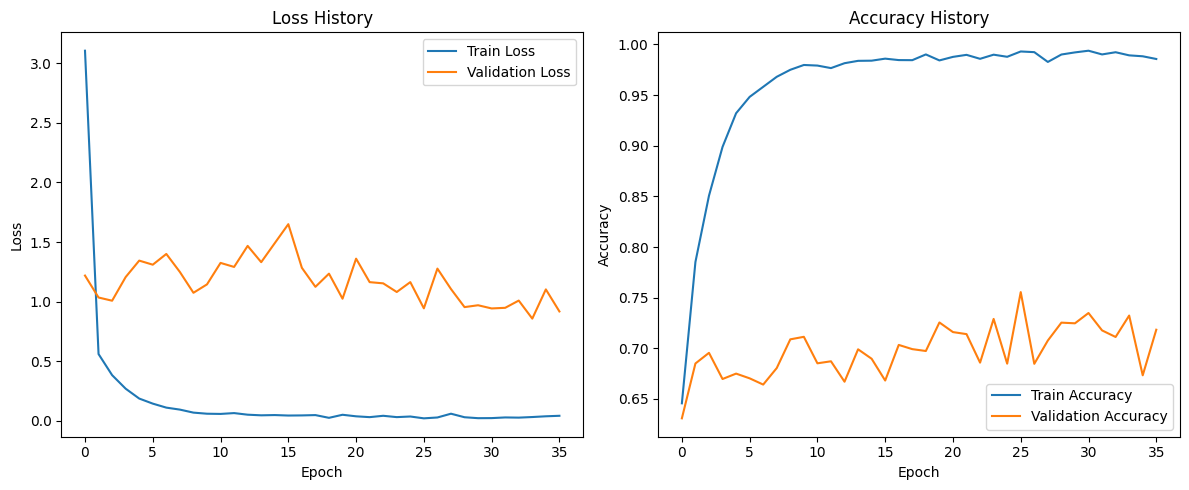


--- Evaluating on Test Set ---
Loading best model from /home/ifihan/multi-dease-detection/results/best_protonet_model.pth

--- Evaluating 4-way 1-shot ---
Test dataset (1-shot): 4 classes found.


Test Results (1-shot):
  Loss: 3.9279
  Accuracy: 0.5514

--- Evaluating 4-way 5-shot ---
Test dataset (5-shot): 4 classes found.


Test Results (5-shot):
  Loss: 0.9379
  Accuracy: 0.7571

--- Evaluating 4-way 10-shot ---
Test dataset (10-shot): 4 classes found.


Test Results (10-shot):
  Loss: 0.6523
  Accuracy: 0.7946

--- Evaluation Complete ---


In [10]:
# --- Main Script ---

import torchvision.models as models
import torch.optim as optim
from matplotlib import pyplot as plt

if __name__ == '__main__':
    # --- Configuration ---
    # Google Drive Mount (ensure this runs in Colab)

    os.makedirs(output_dir, exist_ok=True)
    best_model_path = os.path.join(output_dir, 'best_protonet_model.pth')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Few-Shot Learning Parameters
    TRAIN_NUM_WAYS = 4          # N-way for training
    TRAIN_NUM_SUPPORT = 5       # K-shot for training support set
    TRAIN_NUM_QUERY = 15        # Number of query examples per class during training
    TRAIN_EPISODES = 200        # Number of training episodes per epoch
    VAL_NUM_WAYS = 4            # N-way for validation
    VAL_NUM_SUPPORT = 5         # K-shot for validation (can match training or be different)
    VAL_NUM_QUERY = 15        # Query examples for validation
    VAL_EPISODES = 100         # Number of validation episodes
    TEST_NUM_WAYS = 4           # N-way for testing
    TEST_NUM_SHOTS = [1, 5, 10] # K-shot values to evaluate on test set
    TEST_NUM_QUERY = 15         # Query examples for testing
    TEST_EPISODES = 600         # Number of test episodes (higher for stable results, following ProtoNet paper)

    # Model & Training Parameters
    IMAGE_SIZE = (320, 320) # Target image size (match ResNet input if using standard)
    USE_GRAYSCALE = False   # Use grayscale images?
    LEARNING_RATE = 1e-4
    NUM_EPOCHS = 50
    PATIENCE = 10 # Early stopping patience

    # --- Encoder Setup ---
    # Using a pre-trained ResNet18 as the encoder
    encoder = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    # Modify the final layer - we need features, not classification
    encoder.fc = nn.Identity() # Output features from the layer before fc

    # --- Model, Optimizer, Criterion ---
    model = PrototypicalNetwork(encoder).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss() # Standard loss for classification

    # --- Datasets and DataLoaders ---
    print("Setting up datasets...")
    # Training Set
    train_dataset = FewShotDataset(
        data_dir=data_dir,
        split='train',
        num_ways=TRAIN_NUM_WAYS,
        num_support=TRAIN_NUM_SUPPORT,
        num_query=TRAIN_NUM_QUERY,
        num_episodes=TRAIN_EPISODES,
        target_size=IMAGE_SIZE,
        use_grayscale=USE_GRAYSCALE,
        augment=True # Enable augmentation for training
    )
    train_loader = get_data_loader(train_dataset, shuffle=True)
    print(f"Train dataset: {len(train_dataset.classes)} classes found.")

    # Validation Set (using fixed settings, e.g., 5-way 5-shot)
    val_dataset = FewShotDataset(
        data_dir=data_dir,
        split='test', # Make sure you have a 'validation' split folder
        num_ways=VAL_NUM_WAYS,
        num_support=VAL_NUM_SUPPORT,
        num_query=VAL_NUM_QUERY,
        num_episodes=VAL_EPISODES,
        target_size=IMAGE_SIZE,
        use_grayscale=USE_GRAYSCALE,
        augment=False # No augmentation for validation/testing
    )
    val_loader = get_data_loader(val_dataset, shuffle=False) # No need to shuffle validation
    print(f"Validation dataset: {len(val_dataset.classes)} classes found.")

    # Test datasets will be created later inside the evaluation loop for different shots

    # --- Training Loop ---
    print("\n--- Starting Training ---")
    best_val_accuracy = 0.0
    epochs_without_improvement = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

        # Train one epoch
        train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Evaluate on validation set
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device, description="Validating")
        val_losses.append(val_loss)
        val_accs.append(val_accuracy)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Check for improvement and save best model
        if val_accuracy > best_val_accuracy:
            print(f"Validation accuracy improved ({best_val_accuracy:.4f} -> {val_accuracy:.4f}). Saving model...")
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_path)
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            print(f"No improvement in validation accuracy for {epochs_without_improvement} epochs.")

        # Early stopping
        if epochs_without_improvement >= PATIENCE:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    print("\n--- Training Finished ---")

    # Plotting training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plot_path = os.path.join(output_dir, 'training_history.png')
    plt.savefig(plot_path)
    print(f"Training history plot saved to {plot_path}")
    plt.show()


    # --- Final Evaluation on Test Set ---
    print("\n--- Evaluating on Test Set ---")
    if os.path.exists(best_model_path):
        print(f"Loading best model from {best_model_path}")
        model.load_state_dict(torch.load(best_model_path, map_location=device))
    else:
        print("Warning: No best model found. Evaluating with the last model state.")

    # Test for each specified number of shots
    for num_shots in TEST_NUM_SHOTS:
        print(f"\n--- Evaluating {TEST_NUM_WAYS}-way {num_shots}-shot ---")
        test_dataset = FewShotDataset(
            data_dir=data_dir,
            split='test', # Make sure you have a 'test' split folder
            num_ways=TEST_NUM_WAYS,
            num_support=num_shots, # Use the current num_shots for support
            num_query=TEST_NUM_QUERY,
            num_episodes=TEST_EPISODES,
            target_size=IMAGE_SIZE,
            use_grayscale=USE_GRAYSCALE,
            augment=False # No augmentation
        )
        if not test_dataset.classes:
             print(f"Skipping {num_shots}-shot evaluation: No classes found or insufficient data in 'test' split.")
             continue

        test_loader = get_data_loader(test_dataset, shuffle=False)
        print(f"Test dataset ({num_shots}-shot): {len(test_dataset.classes)} classes found.")

        test_loss, test_accuracy = evaluate(model, test_loader, criterion, device, description=f"Testing {num_shots}-shot")
        print(f"Test Results ({num_shots}-shot):")
        print(f"  Loss: {test_loss:.4f}")
        print(f"  Accuracy: {test_accuracy:.4f}")

    print("\n--- Evaluation Complete ---")